In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import random

from PIL import Image
from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

#**Data directory**

In [2]:
base_dir = '/content/drive/MyDrive/TIFF-PETonlyWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [3]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training lungCancer images: 811
total training normal images: 811


#**Checking patient overlap**

In [4]:
def check_data_leakage(directory1, directory2):
    filenames_dir1 = set(os.listdir(directory1))
    filenames_dir2 = set(os.listdir(directory2))

    common_filenames = filenames_dir1.intersection(filenames_dir2)

    if len(common_filenames) > 0:
        print("Data leakage detected!")
        print("Common image filenames between the directories:", common_filenames)
    else:
        print("No data leakage detected.")

In [5]:
check_data_leakage(train_lungCancer_dir, test_lungCancer_dir)
check_data_leakage(train_normal_dir, test_normal_dir)
check_data_leakage(train_lungCancer_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_lungCancer_dir)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


#**Data visualization**

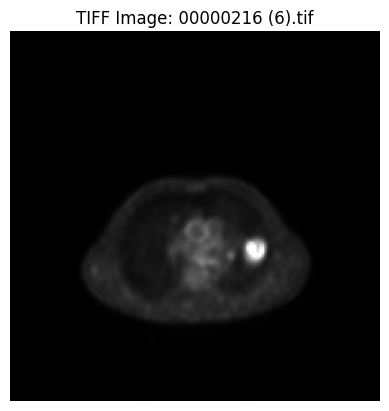

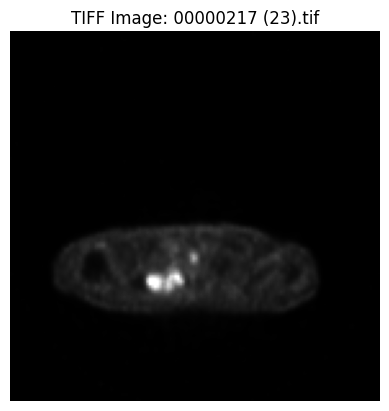

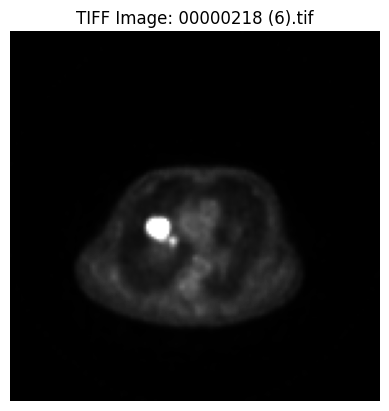

In [6]:
def display_random_tif_images(directory, num_images=3):
    filenames = os.listdir(directory)
    random_images = random.sample(filenames, num_images)

    for filename in random_images:
        image_path = os.path.join(directory, filename)
        img = Image.open(image_path)
        img_array = np.array(img)

        plt.imshow(img_array, cmap='gray')
        plt.title(f"TIFF Image: {filename}")
        plt.axis('off')
        plt.show()

display_random_tif_images(test_lungCancer_dir, num_images=3)

#**Data generation**

In [ ]:
BATCH_SIZE= 80
image_height, image_width = 144, 144

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.05,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,
        target_size=(image_height, image_width),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size=(image_height, image_width),
        batch_size=10,
        class_mode='binary')

#**Defining model**

In [8]:
pre_trained_model = InceptionV3(include_top=False,
                                        weights= 'imagenet',
                                        input_shape = (image_height, image_width, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 71, 71, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 71, 71, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [9]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
# x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)
x = layers.Activation(tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)

last layer output shape:  (None, 3, 3, 2048)


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 71, 71, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 71, 71, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
savingPath = os.makedirs('/content/sample_data/temporaryWeights')
checkpoint_path = '/content/sample_data/temporaryWeights'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/sample_data/temporaryWeights


In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.001), loss= 'binary_crossentropy',
              metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [13]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 20,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 6.2251 - Binary_accuracy: 0.5086 - Precision: 0.5093 - Recall: 0.4723 - TP: 383.0000 - TN: 442.0000 - FN: 428.0000 - FP: 369.0000 - AUC: 0.5094
Epoch 1: val_loss improved from inf to 1.18548, saving model to /content/sample_data/temporaryWeights
21/21 [==============================] - 53s 2s/step - loss: 6.2251 - Binary_accuracy: 0.5086 - Precision: 0.5093 - Recall: 0.4723 - TP: 383.0000 - TN: 442.0000 - FN: 428.0000 - FP: 369.0000 - AUC: 0.5094 - val_loss: 1.1855 - val_Binary_accuracy: 0.4898 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 192.0000 - val_FN: 200.0000 - val_FP: 0.0000e+00 - val_AUC: 0.4071
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.8871 - Binary_accuracy: 0.5037 - Precision: 0.5040 - Recall: 0.4612 - TP: 374.0000 - TN: 443.0000 - FN: 437.0000 - FP: 368.0000 - AUC: 0.5489
Epoch 2: val_loss improved from 1.18548 to 0.80426, saving model to /

##**Plotting Loss and Accuracy**

In [ ]:
plt.plot(history.history['Binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Binary_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Test Loss')
plt.show()